In [142]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

REGRESSION_MODEL_PATH = "models/power_consumption_linear_regression.sav"
DESIGN_MATRIX_PATH = "datasets/design_matrix.csv"
WAYNE_TRIPS_PATH = "datasets/wayne_trips_to_PA.pkl"
TEMP_PATH = "datasets/Temperature.csv"
WAYNE_COLS = ["service_id", "block_id", "trip_id", "shape_dist_traveled", "duration", "time_waiting"]
BUS_BATTERY_CAPACITY = 364


model = joblib.load(REGRESSION_MODEL_PATH)
M = pd.read_csv(DESIGN_MATRIX_PATH)
X1 = pd.read_csv(TEMP_PATH)["Temperature"]
wayne_trips = pd.read_pickle(WAYNE_TRIPS_PATH)[WAYNE_COLS]
wayne_trips["duration_hours"] = wayne_trips.duration.apply(lambda x: x.total_seconds() / (60*60))
wayne_trips["avg_speed"] = wayne_trips.apply(lambda row: row.shape_dist_traveled / (row.duration_hours), axis=1)

X2 = X1 ** 2
X3 = M["Speed"]

# Create bootstrap distribution

B, X3_stdev = wayne_trips.shape[0] * 500, np.std(X3)
bootstrap_wayne = wayne_trips.sample(n=B, replace=True, random_state=42)
bootstrap_wayne["temperature"] = np.random.choice(X1, B, replace=True)
bootstrap_wayne["temp_sq"] = bootstrap_wayne.temperature ** 2
#bootstrap_wayne["speed"] = bootstrap_wayne.avg_speed.apply(lambda x: np.random.normal(loc=x, scale=X3_stdev))
bootstrap_wayne["speed"] = bootstrap_wayne.avg_speed
bootstrap_wayne["predicted_consumption_kW"] = model.predict(bootstrap_wayne.iloc[:, 8:])
bootstrap_wayne["predicted_consumption_kWh"] = bootstrap_wayne.predicted_consumption_kW * bootstrap_wayne.duration_hours

# Group by service_id, block_id, trip_id
trips_total_kWh = bootstrap_wayne.groupby(["trip_id", "service_id", "block_id"])["predicted_consumption_kWh"].quantile(q=0.99)
trips_total_kWh = trips_total_kWh.reset_index().rename({"predicted_consumption_kWh": "predicted_consumption_99th"}, axis="columns")
trips_total_kWh.head()

# Get sums by block ID, service ID
blocks_total_kWh = trips_total_kWh.groupby(["block_id", "service_id"])["predicted_consumption_99th"].sum().reset_index()
blocks_total_kWh["block_is_incomplete"] = (blocks_total_kWh.predicted_consumption_99th > BUS_BATTERY_CAPACITY).astype(int)
blocks_total_kWh["block_kWh_deficit"] = blocks_total_kWh.predicted_consumption_99th - BUS_BATTERY_CAPACITY
blocks_total_kWh.block_kWh_deficit = blocks_total_kWh.block_kWh_deficit.apply(lambda x: 0 if x < 0 else x)

# Join block info back onto trip info
wayne_trips = wayne_trips.merge(blocks_total_kWh, on=["block_id", "service_id"])

#blocks_total_kWh.sort_values(by="block_kWh_deficit", ascending=False)
wayne_trips[wayne_trips.block_id == "191WY001"]

blocks_total_kWh.describe()

,service_id,predicted_consumption_99th,block_is_incomplete,block_kWh_deficit
count,896.000000,896.000000,896.000000,896.000000
mean,3.555804,166.742928,0.103795,4.494659
std,1.302001,119.227695,0.305164,21.228465
min,1.000000,24.218814,0.000000,0.000000
25%,3.000000,68.139616,0.000000,0.000000
50%,4.000000,127.965797,0.000000,0.000000
75%,5.000000,252.105515,0.000000,0.000000
max,7.000000,714.342840,1.000000,350.342840


<Axes: xlabel='predicted_consumption_kW', ylabel='Density'>

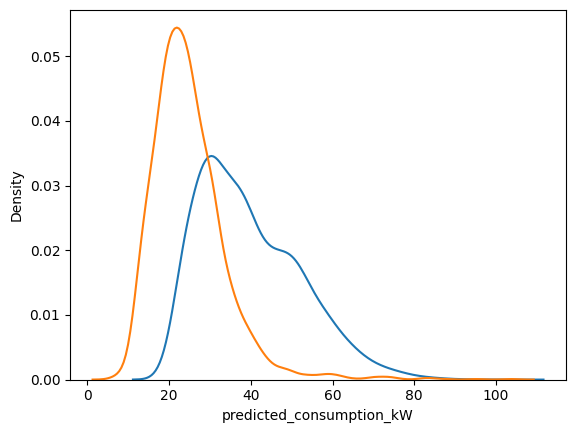

In [133]:
sns.kdeplot(bootstrap_wayne.predicted_consumption_kW, bw_adjust=3)
sns.kdeplot(M["Power Consumption"])

<Axes: xlabel='speed', ylabel='Density'>

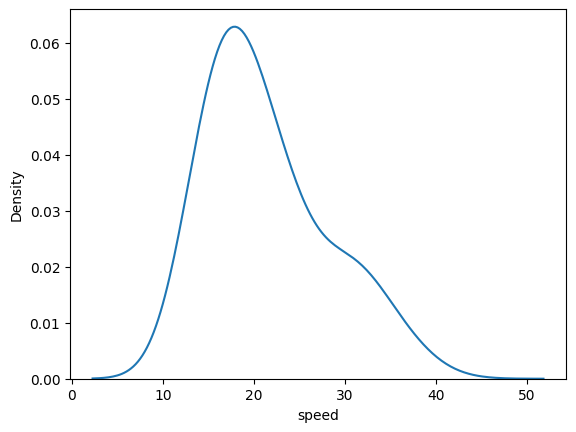

In [137]:
sns.kdeplot(bootstrap_wayne.speed, bw_method=0.5)

In [144]:
service_id_deficits = wayne_trips.groupby("service_id")[["block_kWh_deficit"]].sum().reset_index()
service_id_deficits["num_buses"] = np.ceil(service_id_deficits.block_kWh_deficit / BUS_BATTERY_CAPACITY)
service_id_deficits


,service_id,block_kWh_deficit,num_buses
0,1,7359.727941,21.0
1,2,8674.726582,24.0
2,3,889.010668,3.0
3,4,968.166143,3.0
4,5,985.151493,3.0
5,6,0.000000,0.0
6,7,0.000000,0.0


In [84]:
wayne_trips = pd.read_pickle(WAYNE_TRIPS_PATH)[WAYNE_COLS]
wayne_trips["duration_hours"] = wayne_trips.duration.apply(lambda x: x.total_seconds() / (60*60))
wayne_trips["avg_speed"] = wayne_trips.apply(lambda row: row.shape_dist_traveled / (row.duration_hours), axis=1)

# Do prediction given temp of 7.7 degrees F
wayne_trips["temp_1th_pred_kW"] = wayne_trips.apply(lambda x: x.avg_speed*1.55 - 1.48*7.7 + 0.0105*7.7**2, axis=1)
wayne_trips["temp_1th_pred_kWh"] = wayne_trips.duration_hours * wayne_trips.temp_1th_pred_kW

# Get sums by block ID
blocks_total_kWh = wayne_trips.groupby("block_id")["temp_1th_pred_kWh"].sum().reset_index()
blocks_total_kWh["block_is_incomplete"] = (blocks_total_kWh.temp_1th_pred_kWh > BUS_BATTERY_CAPACITY).astype(int)
blocks_total_kWh["block_kWh_deficit"] = blocks_total_kWh.temp_1th_pred_kWh - BUS_BATTERY_CAPACITY
blocks_total_kWh.block_kWh_deficit = blocks_total_kWh.block_kWh_deficit.apply(lambda x: 0 if x < 0 else x)

# Join block info back onto trip info
wayne_trips = wayne_trips.merge(blocks_total_kWh, on="block_id")

# Get the num of buses needed
service_id_deficits = wayne_trips.groupby("service_id")[["block_is_incomplete", "block_kWh_deficit"]].sum().reset_index()
service_id_deficits["num_buses"] = np.ceil(service_id_deficits.block_kWh_deficit / BUS_BATTERY_CAPACITY)
service_id_deficits

,service_id,block_is_incomplete,block_kWh_deficit,num_buses
0,1,2,201.953890,1.0
1,2,2,201.953890,1.0
2,3,1,100.976945,1.0
3,4,2,201.953890,1.0
4,5,2,201.953890,1.0
5,6,0,0.000000,0.0
6,7,0,0.000000,0.0
